In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
from scipy.special import erf

az.rcParams["plot.max_subplots"] = 80

First, load the output of our inference as an arviz InferenceData object:

In [2]:
#data = az.from_netcdf("ar_z.cdf")
data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_z_tauMax_2_relaxed.cdf")
az.summary(data,["ar_z_std",
                 "ar_z_tau",
                 "logR20",
                 "alpha",
                 "mMin",
                 "log_dmMin",
                 "mu_m1",
                 "sig_m1",
                 "log_f_peak",
                 "mMax",
                 "log_dmMax",
                 "bq",
                 "mu_chi",
                 "logsig_chi",
                 "sig_cost",
                 "nEff_inj_per_event",
                 "min_log_neff"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar_z_std,0.624,0.324,0.008,1.140,0.006,0.004,2482.0,2239.0,1.0
ar_z_tau,1.171,0.491,0.367,1.999,0.006,0.004,7438.0,3081.0,1.0
logR20,-0.369,0.298,-0.864,0.311,0.006,0.004,3345.0,2204.0,1.0
alpha,-3.699,0.362,-4.363,-3.017,0.006,0.005,3635.0,2623.0,1.0
mMin,9.242,0.852,7.504,10.839,0.014,0.010,4067.0,2725.0,1.0
log_dmMin,-0.417,0.361,-1.000,0.175,0.005,0.004,3937.0,2987.0,1.0
mu_m1,34.253,1.863,31.025,37.342,0.042,0.030,3506.0,1616.0,1.0
sig_m1,4.224,2.129,2.000,8.153,0.048,0.040,3477.0,1701.0,1.0
log_f_peak,-2.559,0.269,-3.000,-2.107,0.004,0.003,4004.0,2866.0,1.0
mMax,78.220,13.051,56.408,99.999,0.170,0.122,5749.0,2658.0,1.0


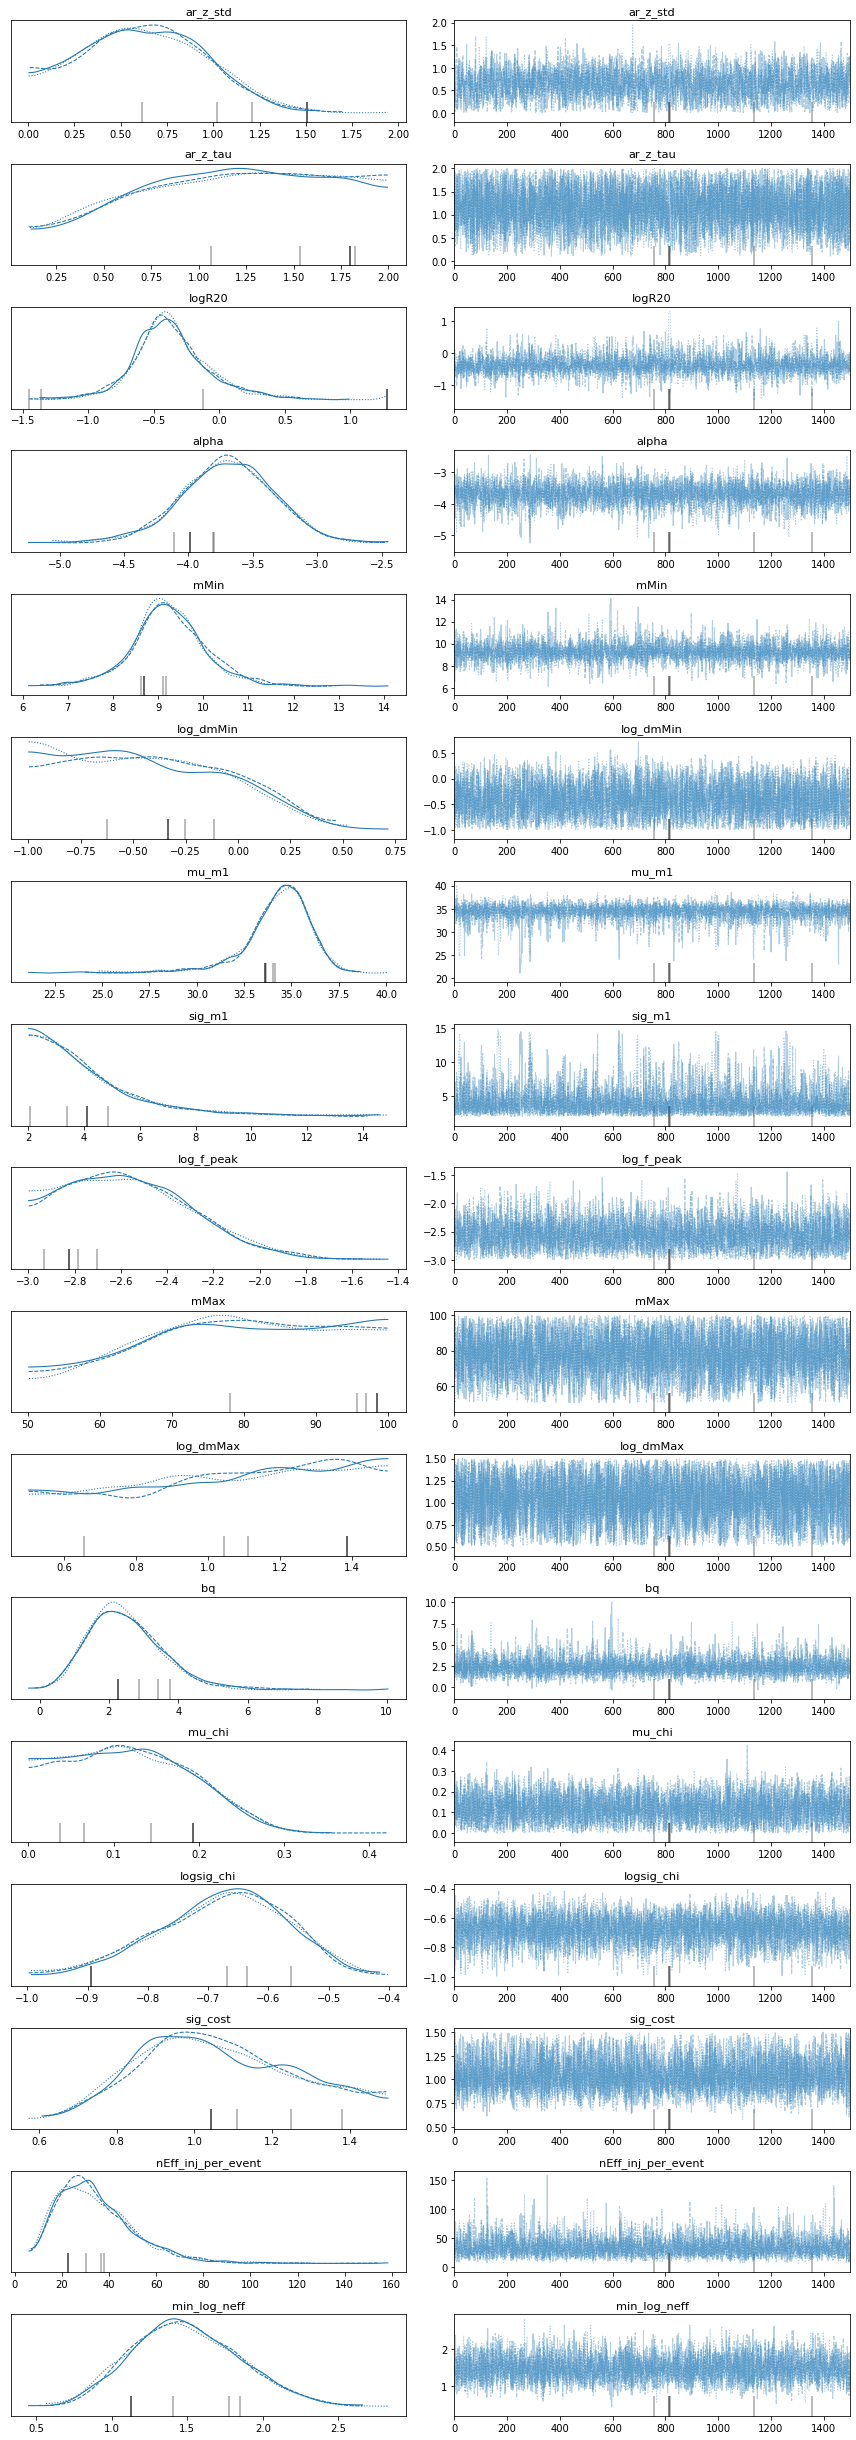

In [3]:
az.plot_trace(data,
              ["ar_z_std",
                 "ar_z_tau",
                 "logR20",
                 "alpha",
                 "mMin",
                 "log_dmMin",
                 "mu_m1",
                 "sig_m1",
                 "log_f_peak",
                 "mMax",
                 "log_dmMax",
                 "bq",
                 "mu_chi",
                 "logsig_chi",
                 "sig_cost",
                 "nEff_inj_per_event",
                 "min_log_neff"], compact=True)
plt.tight_layout()
plt.show()

In [4]:
#z_data = np.load('ar_z_data.npy',allow_pickle=True)[()]
z_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_z_data_tauMax_2_relaxed.npy',allow_pickle=True)[()]
z_values = z_data['z_allSamples']

In [5]:
samps = data.posterior.stack(draws=("chain", "draw"))

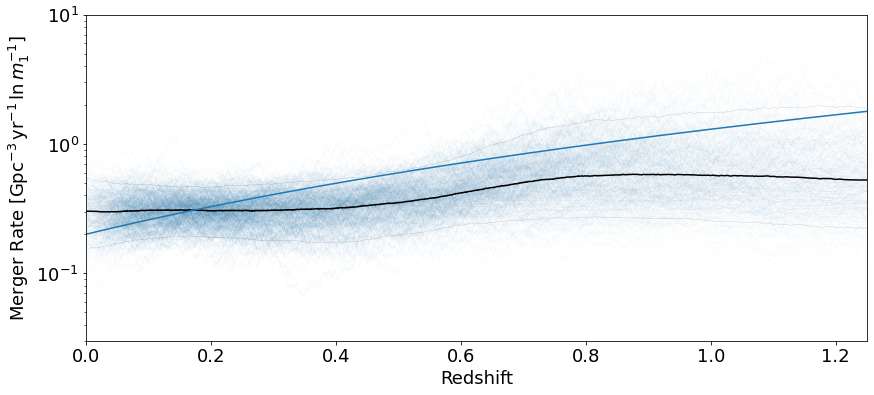

In [6]:
reduced_zs = z_values[::50]
reduced_f_zs = samps['f_zs'][::50]

R_zs = np.zeros((reduced_zs.size,reduced_f_zs.shape[1]))
for i in range(reduced_f_zs.shape[1]):
    R_zs[:,i] = samps.R20[i]*reduced_f_zs[:,i]

fig,ax = plt.subplots(figsize=(14,6))
for i in np.random.choice(range(reduced_f_zs.shape[1]),500):
    ax.plot(reduced_zs,R_zs[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

ax.plot(reduced_zs,np.median(R_zs,axis=1),color='black')
ax.plot(reduced_zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.15)
ax.plot(reduced_zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.15)

zs = np.linspace(0,1.3,300)
ax.plot(zs,0.2*(1.+zs)**2.7)

ax.tick_params(labelsize=18)
ax.set_xlim(0,1.25)
ax.set_ylim(3e-2,10)
#ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xticks([10,30,100])
#ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_xlabel('Redshift',fontsize=18)
ax.set_ylabel('Merger Rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]',fontsize=18)

plt.show()

In [15]:
ratios = np.zeros(reduced_f_zs.shape[1])
for i in range(reduced_f_zs.shape[1]):
    
    R02 = np.interp(0.2,reduced_zs,reduced_f_zs[:,i])
    R08 = np.interp(0.8,reduced_zs,reduced_f_zs[:,i])
    ratios[i] = R08/R02

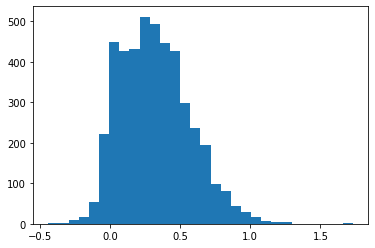

In [17]:
fig,ax = plt.subplots()
ax.hist(np.log10(ratios),bins=30)
plt.show()

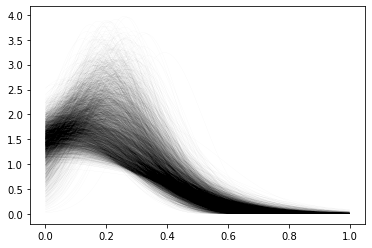

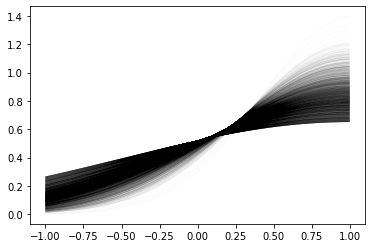

In [9]:
def gaussian(samples,mu,sigma,lowCutoff,highCutoff):
    
    """
    Function defining the probability density due to a truncated Gaussian
    """
    
    a = (lowCutoff-mu)/np.sqrt(2*sigma**2)
    b = (highCutoff-mu)/np.sqrt(2*sigma**2)
    norm = np.sqrt(sigma**2*np.pi/2)*(-erf(a) + erf(b))
    return np.exp(-(samples-mu)**2/(2.*sigma**2))/norm

fig,ax = plt.subplots()
grid = np.linspace(0,1,1000)
for i in range(samps.mu_chi.size):
    
    p_chi = gaussian(grid,samps.mu_chi.values[i],10.**samps.logsig_chi.values[i],-1,1)
    ax.plot(grid,p_chi,color='black',lw=0.1,alpha=0.1)
plt.show()

fig,ax = plt.subplots()
grid = np.linspace(-1,1,1000)
for i in range(samps.mu_chi.size):
    
    #p_cost = gaussian(grid,samps.mu_cost.values[i],samps.sig_cost.values[i],-1,1)
    p_cost = gaussian(grid,1.,samps.sig_cost.values[i],-1,1)

    ax.plot(grid,p_cost,color='black',lw=0.1,alpha=0.1)
plt.show()